In [1]:
import os.path as osp

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

from torch import optim

from helpers.augmentations import RandomHorizontallyFlip, RandomVerticallyFlip,RandomTranspose, Compose
from helpers.utils import AeroCLoader, AverageMeter, Metrics, parse_args
from helpers.lossfunctions import cross_entropy2d

from torchvision import transforms

from networks.resnet6 import ResnetGenerator
from networks.segnet import segnet, segnetm
from networks.myModel_test import DPSMask,ADPSMask,PGADPSMask,fixedMask
from networks.model_utils import init_weights, load_weights

In [2]:
from types import SimpleNamespace

args = SimpleNamespace(
    # 0. Config file
    config_file=None,

    # 1. Data Loading
    bands=5,
    window_size=64,
    use_augs=True,

    # b. ResNet config
    resnet_blocks=6,
    gpu_index=0,

    # Hyperparameters
    batch_size=1,
    init_weights='kaiming',
    epochs=100,
    percentage_Ps=80,
    percentage_As=20,
    temperature=2.0,
    seed=3,
)

In [3]:
args.network_weights_path = 'savedmodels/PGADPS_5bands_80PS_20AsBlock_2seed.pth'
args.sampling = 'PGADPS'

GPU_NUM = args.gpu_index # GPU number
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
args.device = device

net_PGADPS = PGADPSMask(args)

net_PGADPS.load_state_dict(torch.load(args.network_weights_path))
net_PGADPS.eval()
net_PGADPS.to(device)

cuda:0


/tmp/ipykernel_2308611/3395447614.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_PADPS.load_state_dict(torch.load(args.network_weights_path))


PADPSMask(
  (SegNet): ModuleList(
    (0-1): 2 x ResnetGenerator(
      (model): Sequential(
        (0): Conv2d(51, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
        (9): ResnetBlock(
          (conv_block): Sequential(
            (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=Tr

In [4]:
args.network_weights_path = 'savedmodels/DPS_5bands_4seed.pth'
args.sampling = 'DPS'

net_DPS = DPSMask(args)

net_DPS.load_state_dict(torch.load(args.network_weights_path))
net_DPS.eval()
net_DPS.to(device)
    

cuda:0


/tmp/ipykernel_2308611/2385087441.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_DPS.load_state_dict(torch.load(args.network_weights_path))


DPSMask(
  (SegNet): ResnetGenerator(
    (model): Sequential(
      (0): Conv2d(51, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ResnetBlock(
        (conv_block): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(256, 256, kernel_size=(3, 3), str

In [5]:
args.network_weights_path = 'savedmodels/all_5bands_2seed.pth'
args.sampling = 'all'
   
if args.sampling in ["Uniform", "GSS", "all"]:
    net_all = fixedMask(args)
elif args.sampling == 'DPS':
    net_all = DPSMask(args)
elif args.sampling == 'ADPS':
    net_all = ADPSMask(args)
elif args.sampling == 'PGADPS':
    net_all = PGADPS(args)


net_all.load_state_dict(torch.load(args.network_weights_path))
net_all.eval()
net_all.to(device)

cuda:0


/tmp/ipykernel_2308611/4147240558.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_all.load_state_dict(torch.load(args.network_weights_path))


fixedMask(
  (SegNet): ResnetGenerator(
    (model): Sequential(
      (0): Conv2d(51, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ResnetBlock(
        (conv_block): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(256, 256, kernel_size=(3, 3), s

In [6]:
def get_labels():
    return np.asarray(
            [
                    [255, 0, 0],
                    [0, 255, 0],
                    [0, 0, 255],
                    [0, 255, 255],
                    [255, 127, 80],
                    [153, 0, 0],
                    ]
            )
def encode_segmap( mask):
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    for ii, label in enumerate(get_labels()):
        label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
    label_mask = label_mask.astype(int)
    return label_mask

In [7]:
image_file_name = 'image_1504_64'

In [8]:
hsi = np.load('/home/bkang/DPS/Hyperspectral/Aerial Data/Image64/Data-right/HSI-rad/'+image_file_name+'.npy')
hsi = np.clip(hsi.astype(np.float32), 0, 2**14)/2**14
hsi = np.transpose(hsi, (2, 0, 1))
hsi = torch.from_numpy(hsi)

label = cv2.imread('/home/bkang/DPS/Hyperspectral/Aerial Data/Image64/Data-right/Labels/'+image_file_name+'.tif')
label = label[:,:,::-1]
label = encode_segmap(label)
label = torch.from_numpy(np.array(label)).long()

In [9]:
net_PADPS.eval()
net_DPS.eval()
net_all.eval()

with torch.no_grad():
    label_pred_PADPS,mask = net_PADPS(hsi.unsqueeze(0).to(device))
    label_pred_PADPS = label_pred_PADPS[:,:,:,:,-1].max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()

with torch.no_grad():
    label_pred_DPS,mask = net_DPS(hsi.unsqueeze(0).to(device))
    label_pred_DPS = label_pred_DPS[:,:,:,:,-1].max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()

with torch.no_grad():
    label_pred_all = net_all(hsi.unsqueeze(0).to(device))
    label_pred_all = label_pred_all[:,:,:,:,-1].max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()

[]

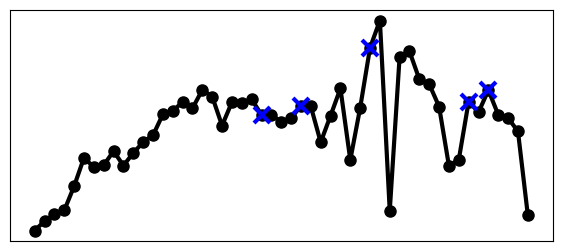

In [10]:
fig, ax = plt.subplots(1, figsize=(7, 3))
band_range=np.arange(400, 901, 10)
SS_index=mask[0,:,0,0].cpu().detach().numpy()
indices = np.where(SS_index == 1)[0]
band_range2=band_range[indices]

plt.plot(band_range,hsi[:,32,32],'-ko', linewidth=3,markersize=8)
plt.plot(band_range2,hsi[indices,32,32],'bx',markeredgewidth =3.0, markersize=12)

ax.set_xticks([]) 
ax.set_yticks([]) 


(-0.5, 63.5, 63.5, -0.5)

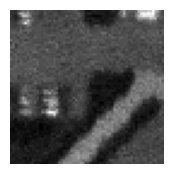

In [11]:
## 0,1,...,25,26,...,49,50
fig, ax = plt.subplots(1, figsize=(2, 2))
plt.imshow(hsi[0,:,:],cmap='gray')
fig.patch.set_facecolor('none')  # Make figure background transparent

plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

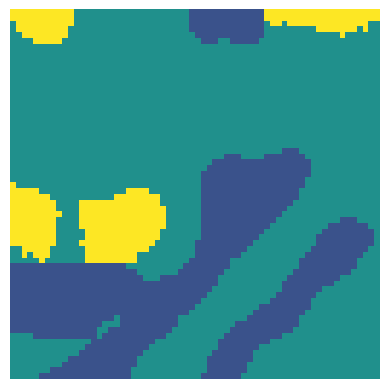

In [12]:
## 1,2, 189,190, 382,383
fig, ax = plt.subplots(1)
plt.imshow(label_pred_all,vmin=0,vmax=4)
# fig.patch.set_facecolor('none')  # Make figure background transparent

plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

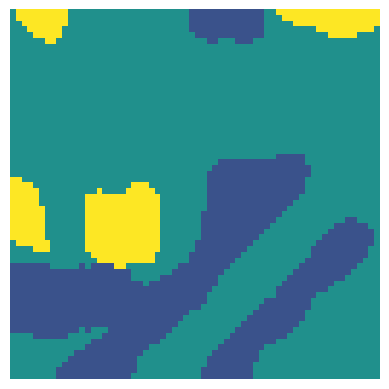

In [13]:
## 1,2, 189,190, 382,383
fig, ax = plt.subplots(1)
plt.imshow(label_pred_PADPS,vmin=0,vmax=4)
# fig.patch.set_facecolor('none')  # Make figure background transparent

plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

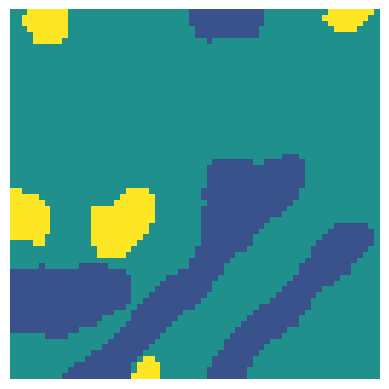

In [14]:
## 1,2, 189,190, 382,383
fig, ax = plt.subplots(1)
plt.imshow(label_pred_DPS,vmin=0,vmax=4)
# fig.patch.set_facecolor('none')  # Make figure background transparent

plt.axis('off')